# Understanding Gender Differences in Tweets with Deep Learning 

***

## Summer Chambers (ssc4mc), Keyu Chen (km5ar), Hannah Frederick (hbf3k)  

The .csv file that we read in can be found here: https://www.kaggle.com/crowdflower/twitter-user-gender-classification

The code that we source from can be found here: https://www.kaggle.com/gcdatkin/deep-recurrent-nn-for-gender-classification#Data-Every-Day

Ensemble article: https://sailajakarra.medium.com/ensemble-scikit-learn-and-keras-be93206c54c4


In [ ]:
#while True:pass

In [ ]:
!pip install yellowbrick
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB


import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [ ]:
#data = pd.read_csv(r"gender-classifier-DFE-791531.csv",
#                   encoding = "latin1")
data = pd.read_csv('/content/gender-classifier-DFE-791531.csv', encoding='latin-1')

In [ ]:
# Encode unknown values in the target column as np.NaN
data['gender'] = data['gender'].replace('unknown', np.NaN)
    
# Drop rows with missing target values
gender_nas = data[data['gender'].isna()].index
data = data.drop(gender_nas, axis=0).reset_index(drop=True)

gender_brand = data[data['gender'] == 'brand'].index
data = data.drop(gender_brand, axis=0).reset_index(drop=True)
data['gender'].unique()

array(['male', 'female'], dtype=object)

In [ ]:
data = data.loc[:,["gender", "description","text"]]
data.dropna(axis = 0, inplace = True)
data["description"] = data["description"].astype('str') + ' ' + data["text"]
data.gender = [1 if i == "female" else 0 for i in data.gender]
data = data.loc[:,["gender", "description"]]
data.dropna(axis = 0, inplace = True)

In [ ]:
data['gender'].unique()

array([0, 1])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11194 entries, 0 to 12893
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gender       11194 non-null  int64 
 1   description  11194 non-null  object
dtypes: int64(1), object(1)
memory usage: 262.4+ KB


In [ ]:
description_list = []
for description in data.description:
    #Regular Expression
    description = re.sub("[^a-zA-Z]", " ", description)
    description = description.lower()
    description = nltk.word_tokenize(description)
    #Lemmatazation
    lemma = nltk.WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
    description = " ".join(description)
    description_list.append(description)


FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff6e120e10>,
                    color='orange',
                    features=['aaron', 'ab', 'abc', 'ability', 'able',
                              'absolute', 'absolutely', 'abt', 'abuse', 'ac',
                              'academic', 'academy', 'acc', 'accent', 'accept',
                              'accepted', 'access', 'accident', 'accidentally',
                              'according', 'account', 'accountant', 'ace',
                              'achieve', 'achievement', 'acoustic', 'act',
                              'acting', 'action', 'active', ...],
                    n=None, orient='v')

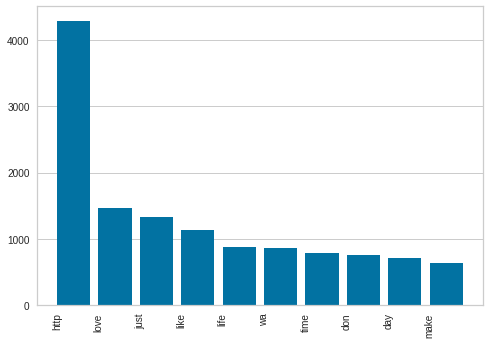

In [ ]:
# Bag of Words
max_features = 5000
count_vectorizer = CountVectorizer(max_features=max_features,stop_words = "english")
sparce_matrix = count_vectorizer.fit_transform(description_list).toarray()
features = count_vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v', n = 10, color = "orange")
visualizer.fit(sparce_matrix)
#visualizer.show()

In [ ]:
y = data.iloc[:, 0].values
x = sparce_matrix

In [ ]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)

In [ ]:
len(y_test)

1120

In [ ]:
# Random Forest 
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print("Accuracy:{:.3%}".format(accuracy_score(y_test, y_pred)))

Accuracy:66.339%


In [ ]:
coefs = (rf.feature_importances_)
sparse_mat = count_vectorizer.fit_transform(description_list)
top_fifteen = np.argpartition(coefs, -15)[-15:]
[features[feature] for feature in top_fifteen]

['feminist',
 'life',
 'wa',
 'mom',
 'just',
 'game',
 'like',
 'fan',
 'father',
 'girl',
 'man',
 'football',
 'sport',
 'love',
 'http']

In [ ]:
# Logistic Regression
lr = LogisticRegression(random_state = 42)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
accuracy = 100.0 * accuracy_score(y_test, y_pred)
print("Accuracy:{:.3%}".format(accuracy_score(y_test, y_pred)))

Accuracy:66.339%


In [ ]:
female_coefs = lr.coef_[0]
sparse_mat = count_vectorizer.fit_transform(description_list)
top_fifteen = np.argpartition(female_coefs, -15)[-15:]
result = [features[feature] for feature in top_fifteen]
for word in result:
  print(f'\item "{word}"')

\item "bathroom"
\item "makeup"
\item "weight"
\item "ac"
\item "alcohol"
\item "goddess"
\item "camgirl"
\item "circle"
\item "alumna"
\item "feminist"
\item "focus"
\item "mother"
\item "baker"
\item "dress"
\item "girl"


In [ ]:
male_coefs = -(lr.coef_[0])
sparse_mat = count_vectorizer.fit_transform(description_list)
top_fifteen = np.argpartition(male_coefs, -15)[-15:]
result = [features[feature] for feature in top_fifteen]
for word in result:
  print(f'\item "{word}"')

\item "mike"
\item "bread"
\item "niallofficial"
\item "male"
\item "meditation"
\item "shoot"
\item "political"
\item "knight"
\item "dnt"
\item "supporting"
\item "musician"
\item "wrestling"
\item "abt"
\item "mufc"
\item "father"


In [ ]:
# K Nearest Neighbors
#knn = KNeighborsClassifier(n_neighbors = 2)
#knn.fit(x_train, y_train)
#y_pred = knn.predict(x_test)
#print("Accuracy:{:.3%}".format(accuracy_score(y_test, y_pred)))

In [ ]:
# Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
print("Accuracy:{:.3%}".format(accuracy_score(y_test, y_pred)))

Accuracy:66.696%


In [ ]:
# Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
print("Accuracy:{:.3%}".format(accuracy_score(y_test, y_pred)))

Accuracy:60.893%


In [ ]:
#log_clf = LogisticRegression(solver="lbfgs", random_state=42)
#rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
#svm_clf = SVC(gamma="scale", random_state=42,probability=True)
# Keras Model
def build_nn():
    model= keras.models.Sequential([
                       keras.layers.Dense(50,activation='relu',input_shape=[1000]),
                       keras.layers.Dense(1,activation='sigmoid')
])
    model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

In [ ]:
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_nn,
                            epochs=3,
                            verbose=False)

In [ ]:
keras_clf._estimator_type = "classifier"

In [ ]:
model = build_nn()
model.fit(x_train,
          y_train)

280/280 [==============================] - 1s 2ms/step - loss: 0.6768 - accuracy: 0.5725


In [ ]:
results = model.evaluate(x_test, y_test, verbose=True)
print("Model Accuracy: {:.2f}%".format(results[1] * 100))

70/70 [==============================] - 0s 1ms/step - loss: 0.6209 - accuracy: 0.6414
Model Accuracy: 64.14%


In [ ]:
voting = VotingClassifier(
             estimators=[("rf",rf),
                          ("lr",lr),
                        #  ("knn",knn),                                      
                          ("mnb",mnb),
                   #       ("nb",nb),
                         ('keras',keras_clf)], 
             voting='soft',
             flatten_transform=True)

In [ ]:
votingC = voting.fit(x_train,y_train)
print(accuracy_score(votingC.predict(x_test),y_test))

0.6574363555158553


In [ ]:
y_pred1 = votingC.predict(x_test)

In [ ]:
#https://sailajakarra.medium.com/ensemble-scikit-learn-and-keras-be93206c54c4

In [ ]:
for clf in (rf, lr,  mnb,  keras_clf, voting): #knn, nb,
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.6467172845020098
LogisticRegression 0.6467172845020098
MultinomialNB 0.6440375167485485
KerasClassifier 0.6440375167485485
VotingClassifier 0.6534167038856632


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred1)
clr = classification_report(y_test, y_pred1, target_names=[ 'male','female'])

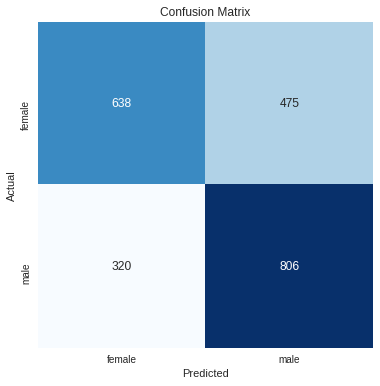

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ['female', 'male'])
plt.yticks(np.arange(2) + 0.5, ['female', 'male'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n\n", clr)

Classification Report:

               precision    recall  f1-score   support

        male       0.67      0.57      0.62      1113
      female       0.63      0.72      0.67      1126

    accuracy                           0.64      2239
   macro avg       0.65      0.64      0.64      2239
weighted avg       0.65      0.64      0.64      2239



In [ ]:
while True:pass

KeyboardInterrupt: ignored